In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

import common.loss_utils as loss_utils

import sys
sys.path.append('./dgmr_original')
import dgmr


In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [7]:
p = pathlib.Path('data/test.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [8]:
times.shape, data.shape

((2189,), (2189, 325, 400))

In [9]:
_MEDIAN_PIXEL = 212.0
_IQR = 213.0

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEDIAN_PIXEL, _IQR),
])

In [23]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)
        self.tsfm = tsfm
        
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(all_data)
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [24]:
x, y = ds[0]

In [25]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

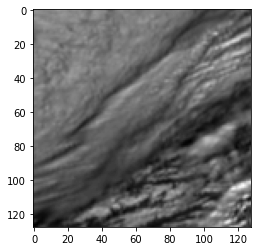

In [26]:
plt.imshow(x[-1], cmap='gray')

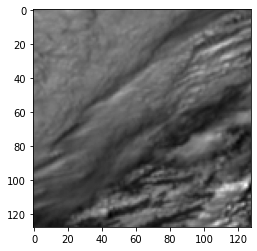

In [27]:
plt.imshow(y[0], cmap='gray')

In [16]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=192,
)

lcs = dgmr.common.LatentConditioningStack(
    shape=(8 * 1, 128 // 32, 128 // 32),
    output_channels=384,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=384,
    context_channels=192,
)

model = dgmr.generators.Generator(ccs, lcs, sampler)
model.load_state_dict(torch.load('weights/dgmr_64/dgmr_epochs=25_loss=0.29322773163492644.pt'))
model = model.to(DEVICE)


In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 13399657 trainable parameters


In [18]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [28]:
model.eval()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)
final_layer = torch.nn.AvgPool2d(kernel_size=2)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)
for i, (srcs, trgs) in enumerate(pbar):
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    x = torch.tanh(x)
    
    preds = []
    for _ in range(1):
        with torch.no_grad():
            p = model(x)
            preds.append(p)
    preds = torch.mean(torch.stack(preds, dim=0), dim=0)
    
    b, t, c, h, w = preds.shape
    preds = preds.reshape(b, t * c, h, w)
    preds = final_layer(preds)
    preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
    
    y = y[:,:,:,32:96,32:96] * _IQR + _MEDIAN_PIXEL
    preds = preds * _IQR + _MEDIAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

Avg Score: 0.7012246257545032: 100%|██████████| 135/135 [00:40<00:00,  3.34it/s]


In [29]:
scores = np.array(scores)
scores.mean()

0.7012246257545035

In [31]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.72458274, 0.73301264, 0.73865677, 0.7377286 , 0.73375509,
       0.72867666, 0.72309984, 0.71734142, 0.71183307, 0.70706793,
       0.70255668, 0.69848873, 0.69457086, 0.6914377 , 0.68843584,
       0.68567421, 0.68332313, 0.68099579, 0.67883562, 0.67708538,
       0.67539297, 0.67374351, 0.67221967, 0.67087617])

In [32]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [33]:
choice = 6
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.724126799367928

In [41]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

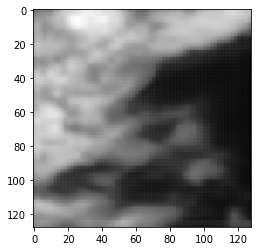

In [42]:
plt.imshow(out[0,0], cmap='gray')

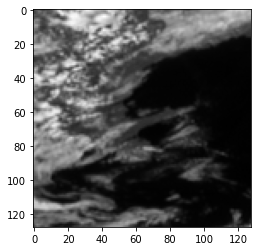

In [43]:
plt.imshow(true[0,0], cmap='gray')

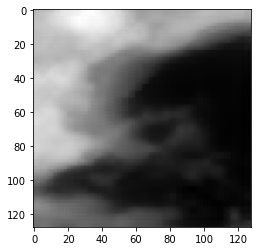

In [45]:
plt.imshow(out[0,-1], cmap='gray')

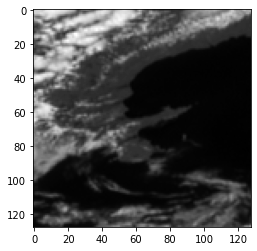

In [46]:
plt.imshow(true[0,-1], cmap='gray')